# Visualizing & Making Predictions with Financial Data

In this module, we design an algorithm that predicts trends in the close prices of [Stooq Index Data](https://stooq.com/db/).
More info on remote data access can be found with the [Pandas Data Reader Documentation](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#stooq-index-data). 

The following packages are required to run the attached code: 

- [Plotly](https://plotly.com/python/)
- [Pandas Datareader](https://pandas-datareader.readthedocs.io/en/latest/)
- [Plotly Express](https://plotly.com/python/plotly-express/)
- [Pandas](https://pandas.pydata.org/docs/)
- [Matplotlib.pylab](https://matplotlib.org/2.0.2/api/pyplot_api.html)
- [Numpy](https://numpy.org/doc/)
- [Datetime](https://docs.python.org/3/library/datetime.html)

---

We begin by importing the relevant libraries:

---

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import pandas_datareader as web
import datetime as dt

import plotly.express as px

--- 

Next, we import the data:

---

In [14]:
data = web.DataReader('^DJI', 'stooq')
data.head

<bound method NDFrame.head of                 Open      High       Low     Close     Volume
Date                                                         
2021-11-09  36404.53  36416.98  36173.07  36319.98  220532093
2021-11-08  36416.46  36565.73  36334.42  36432.22  360384779
2021-11-05  36268.75  36484.75  36190.20  36327.95  534285391
2021-11-04  36107.46  36168.03  35986.48  36124.23  361561660
2021-11-03  36059.09  36178.51  35891.73  36157.58  320354913
...              ...       ...       ...       ...        ...
2016-11-16  18909.85  18909.85  18825.89  18868.14   87328489
2016-11-15  18858.21  18925.26  18806.06  18923.06  100747890
2016-11-14  18876.77  18934.05  18815.75  18868.69  112345564
2016-11-11  18781.65  18855.78  18736.96  18847.66  107229799
2016-11-10  18603.14  18873.66  18603.14  18807.88  164380355

[1258 rows x 5 columns]>

--- 

In order to visualize our data, we create a line graph using Plotly Express:


---

In [15]:
px.line(data, y = ['Open', 'High', 'Low', 'Close'])

--- 

Now, we partition the data, with the first 100 rows of the "Close" column serving as our "training" data and the rest as our "testing" data. Like the name suggests, we will train our algorithm on our "training" data and compare our algorithm's predictions to the "testing" data. 

--- 

In [16]:
train_data = pd.DataFrame(data['Close'].iloc[:100]) 
train_data

,Close
Date,
2021-11-09,36319.98
2021-11-08,36432.22
2021-11-05,36327.95
2021-11-04,36124.23
2021-11-03,36157.58
...,...
2021-06-25,34433.84
2021-06-24,34196.82
2021-06-23,33874.24


--- 

In order to ensure all of our data types are consistent, we set our training data to be of data type 'float64':

--- 

In [17]:
train_data['Close'] = train_data['Close'].astype(float)

--- 

There are many ways we can choose to visualize our testing data. Below are some examples of generated plots using the Matplotlib and Plotly Express libraries:

---

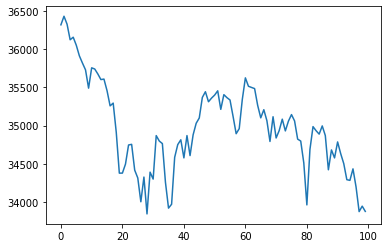

In [18]:
plt.plot(train_data['Close'].to_numpy())

In [19]:
px.line(train_data)

# Training the algorithm:

We create a data matrix in which the columns contain the Close test data on day $i = 1, ..., 7$:

In [20]:
for i in range(1,8):
    train_data[f'lag_{i}'] = train_data['Close'].shift(i)
train_data = train_data.dropna() # drops the N/A values
train_data

# create an array for the columns with the previous days' data:
cols = [f'lag_{i}' for i in range(1,8)]

# convert the training data into numpy arrays. again, to keep the data types consistent, we use float64 for all of our variables. 
A = train_data[cols].to_numpy(dtype='float64')
y = train_data['Close'].to_numpy(dtype='float64')

--- 

We want to find a vector w such that:

- $w_i$, i = 1, ..., 7, such that: $w_1*lag_1^j + ... + w_7*lag_7^j ~= Close^j$, where j = 1, ..., 93 corresponds to the rows of our data matrix.

- $Aw ~= y$. 

We employ the use of Normal Equations in order to minimize the residual, $|Aw - y|$: 

$A^{\top} A \hat{w} = A^{\top} y \to \hat{w} = (A^{\top} A)^{-1} A^{\top} y$ 

Note that this is computationally expensive! For larger-scale problems, it's more efficient to use gradient-descent, but for our purposes, the Normal Equations should work just fine.

--- 

In [21]:
# we use the numpy library to perform matrix/vector multiplication:
w_hat = np.linalg.inv(A.T @ A) @ A.T @ y
train_data['predictions'] = A @ w_hat

/Users/rachaelalfant/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



---

Now, we use the Plotly Express library again to see how our predictions match up to the training data:

---

In [22]:
px.line(train_data, y = ['Close', 'predictions'])

---

As you can see, our predictions were relatively good. Now, we can try to improve our algorithm by introducing bias. The addition of bias is especially needed on high volatility days:
$y = w_1*\text{lag}_1 + b$. 

---

In [23]:
# we add a column of 1's to our training data (i.e. we add an eighth weight to account for bias):
train_data['ones'] = np.ones(len(train_data['Close']))
cols.append('ones')

# introduce bias
A_bias = train_data[cols].to_numpy(dtype='float64')
w_hat_bias = np.linalg.inv(A_bias.T @ A_bias) @ A_bias.T @ y

train_data['predictions_with_bias'] = A_bias @ w_hat_bias

px.line(train_data, y=['Close', 'predictions', 'predictions_with_bias'])

/Users/rachaelalfant/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/rachaelalfant/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



--- 

Since it's relatively difficult to discern whether our algorithm performed better with the addition of bias, we introduce a way to calculate our error. We use the mean root squared error, with the following formula: 

MRSE = $\frac{1}{2m} \sqrt{\sum_{i=1}^m (y_i - \hat{y}_i)^2}$ 

--- 

In [24]:
y
y_hat1 = train_data['predictions'].to_numpy(dtype='float64')
y_hat2 = train_data['predictions_with_bias'].to_numpy(dtype='float64')

# define the MSRE:
def MSRE(labels, predictions):
    return np.sqrt((labels - predictions)@(labels - predictions))

print(f'In-Sample MSRE without bias = {MSRE(y, y_hat1)}')
print(f'In-Sample MSRE with bias = {MSRE(y, y_hat2)}')

In-Sample MSRE without bias = 2258.6047565495523
In-Sample MSRE with bias = 2219.166328535122


--- 

As our error indicates, our algorithm performed slightly better with the addition of bias. In order to better observe changes in data, we can also change the scale our data is plotted on.

---

In [25]:
# using a log scale:
data['log_Close'] = np.log(data['Close'])
px.line(data, y = 'log_Close')

--- 

Finally, we test our algorithm on our test data, i.e. the data we did not use to train the algorithm:

---

In [26]:
test_data = data['Close'].iloc[-100:]
test_data = pd.DataFrame(test_data)

# again, we create our data matrix over the span of a week, and add a column of ones that we can use to introduce bias. 
cols = []
for i in range(1,8):
    test_data[f'lag_{i}'] = test_data['Close'].shift(i)
    cols.append(f'lag_{i}')
test_data = test_data.dropna()
test_data['ones'] = np.ones(len(test_data))
cols.append('ones')

test_data['predictions'] = test_data[cols].to_numpy() @ w_hat_bias

y = test_data['Close'].to_numpy()
y_hat = test_data['predictions'].to_numpy()
print(f'MSRE = {MSRE(y, y_hat)}')

MSRE = 13824.728729214323


In [27]:
px.line(test_data, y = ['Close', 'predictions'])

---

Interestingly, although our algorithm did not exactly predict the Close prices, it accurately identified the trends and trajectories of these prices. 

--- 